# Sample Point Creation

#### Dask import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33832")
client

Client Scheduler: tcp://127.0.0.1:33832 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 9 Cores: 9 Memory: 57.98 GB


<br>

#### Choices for data

In [2]:
floatDataAdress = 'Argo_T_profiles_very_small_subset.csv'

<br>

#### Importing Libaries

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
print("Imports complete")

Imports complete


<br>

#### Loading Data

In [4]:
dfFloatData = pd.read_csv(floatDataAdress)
dfFloatData = dfFloatData.rename({"x":"Lon", "y":"Lat"}, axis="columns")
dfFloatLoc = dfFloatData[["Lon","Lat"]]
dfFloatLoc.name = "Data Set"
dfFloatLocUniq = dfFloatLoc.drop_duplicates()
print(len(dfFloatLoc), len(dfFloatLocUniq))
print("Float locations loaded to dfFloatLoc")
dfFloatLoc.head()

2845 2843
Float locations loaded to dfFloatLoc


,Lon,Lat
0,51.582001,-45.755001
1,92.547997,-43.222000
2,89.600998,-56.223000
3,115.977997,-45.905998
4,64.942001,-50.344002


In [5]:
dfFloatLoc[dfFloatLoc["Lat"]==-80.001] #remove non-unique data points?

,Lon,Lat
2680,-80.001,-80.001
2781,-80.001,-80.001
2782,-80.001,-80.001


In [6]:
dfFloatLocUniq[dfFloatLocUniq["Lat"]==-80.001]

,Lon,Lat
2680,-80.001,-80.001


In [7]:
#Testing of randomisation and selection
rowMask = np.full(2845, False, dtype=bool)
sampledIndex = sampleIndex = np.random.choice(5, 2, replace=False)
for i in sampledIndex:
    rowMask[i] = True
removal = dfFloatLoc[rowMask]
print(sampledIndex)
removal

[2 4]


,Lon,Lat
2,89.600998,-56.223000
4,64.942001,-50.344002


<br>

#### Calculation Functions
<b>Functions:</b><br>
<ul>
<li>pickRand - Takes in data frame and returns sampled data frame with a randomly selected number of rows from the input data frame, controled by the second input variable to the function.
</ul>

In [8]:
def pickRand(dataFrame, sampleNumbers):
    frameLen = len(dfFloatLoc)
    if frameLen <= sampleNumbers: #More or equal samples are asked for than exist in the dataFrame
        print("Sample number is equal to or exceeds size of data frame, returning "+str(frameLen)+" data points.")
        return dataFrame
    else:
        rowMask = np.full(frameLen, False, dtype = bool)
        sampleIndex = np.random.choice(range(frameLen), sampleNumbers, replace=False)
        for i in sampleIndex:
            rowMask[i] = True
        sampledDataFrame = dataFrame[rowMask]
        sampledDataFrame.name = "Sampled data - "+str(sampleNumbers)
        return sampledDataFrame

print("Calculation functions defined")

Calculation functions defined


<br>

#### Plotting Functions
<b>Functions:</b><br>
<ul>
<li>locationPlot - Plots locations of an input data set on a map.
<li>latDistribution - Plots latitude distribution of an input data set as a histogram.
<li>latDistributionCompare - Plots latitude distribution of two input data sets against each other as histograms.
<li>lonDistribution - Plots longitude distribution of an input data set as a histogram.
<li>lonDistributionCompare - Plots longitude distribution of two input data sets against each other as histograms.
</ul>

In [9]:
def locationPlot(dataSet, size, plotNo):
    plt.figure(plotNo, figsize=size)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.coastlines()
    ax.gridlines()
    #plot.scatter(floatLon, floatLat, ....
    plt.scatter(dataSet['Lon'], dataSet['Lat'], color="Red", transform=ccrs.PlateCarree(),cmap='RdBu_r')
    plt.plot(np.arange(0,360,1),np.ones(360)*-29.5, transform=ccrs.PlateCarree(), color="Black")
    #dataSet.scatter(x='lon', y='lat', color="Red", transform=ccrs.PlateCarree(),cmap='RdBu_r')
    plt.title("Sample Locations")
    
def latDistribution(dataSet, plotNo):
    plt.figure(plotNo)
    latDistri = np.arange(-89.5, -29.4, 2.5)
    plt.hist(dataSet["Lat"], bins = latDistri)
    plt.title("Latitude distribution of data points")
    
def latDistributionCompare(dataSet1, dataSet2, plotNo):
    plt.figure(plotNo)
    latDistri = np.arange(-89.5, -29.4, 2.5)
    latWeights1 = np.ones_like(dataSet1["Lat"])/float(len(dataSet1["Lat"]))
    latWeights2 = np.ones_like(dataSet2["Lat"])/float(len(dataSet2["Lat"]))
    plt.hist(dataSet1["Lat"], bins = latDistri, weights = latWeights1, alpha=0.5, label=dataSet1.name)
    plt.hist(dataSet2["Lat"], bins = latDistri, weights = latWeights2, alpha=0.5, label=dataSet2.name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Latitude distribution of data points compared to main data set")
    
def lonDistribution(dataSet, plotNo):
    plt.figure(plotNo)
    latDistri = np.arange(-180, 180, 10)
    plt.hist(dataSet["Lon"], bins = latDistri)
    plt.title("Longitude distribution of data points")
    
def lonDistributionCompare(dataSet1, dataSet2, plotNo):
    plt.figure(plotNo)
    latDistri = np.arange(-180, 180, 10)
    lonWeights1 = np.ones_like(dataSet1["Lon"])/float(len(dataSet1["Lon"]))
    lonWeights2 = np.ones_like(dataSet2["Lon"])/float(len(dataSet2["Lon"]))
    plt.hist(dataSet1["Lon"], bins = latDistri, weights = lonWeights1, alpha=0.5, label=dataSet1.name)
    plt.hist(dataSet2["Lon"], bins = latDistri, weights = lonWeights2, alpha=0.5, label=dataSet2.name)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Longitude distribution of data points compared to main data set")
    
print("Plotting functions defined")

Plotting functions defined


<br>

#### Displaying of data
<b>Demonstration of random sampling - 10 small scale samples</b>

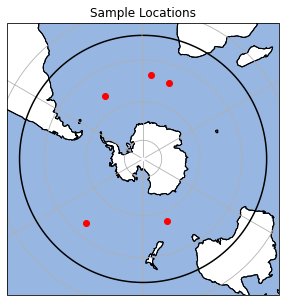

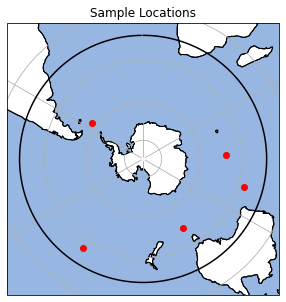

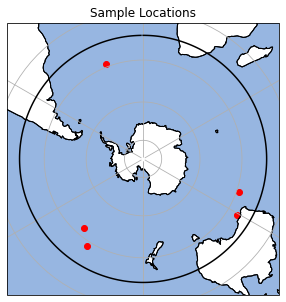

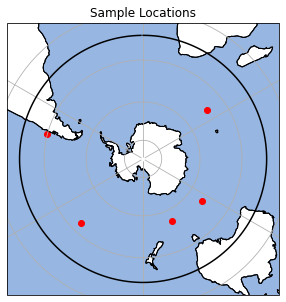

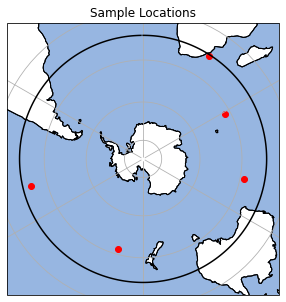

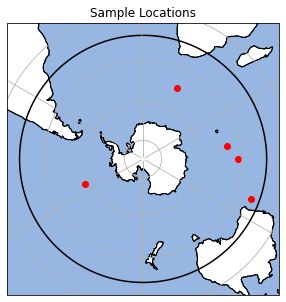

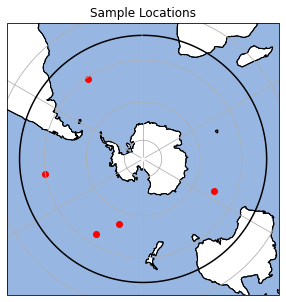

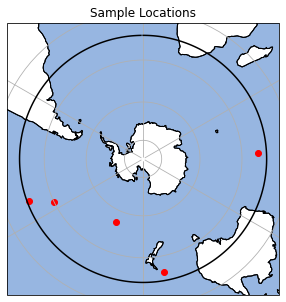

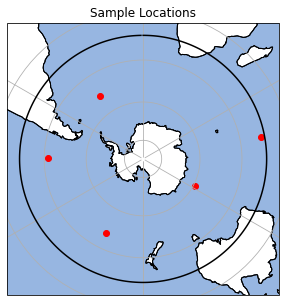

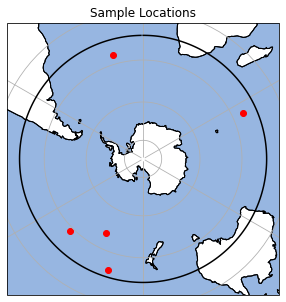

In [10]:
randomFloatLocationsList = []
for i in range(10):
    randomFloatLocations = pickRand(dfFloatLoc, 5)
    randomFloatLocationsList.append(randomFloatLocations)
    locationPlot(randomFloatLocations, (5,5), i)

<br>
<b>Large Random Sample</b>

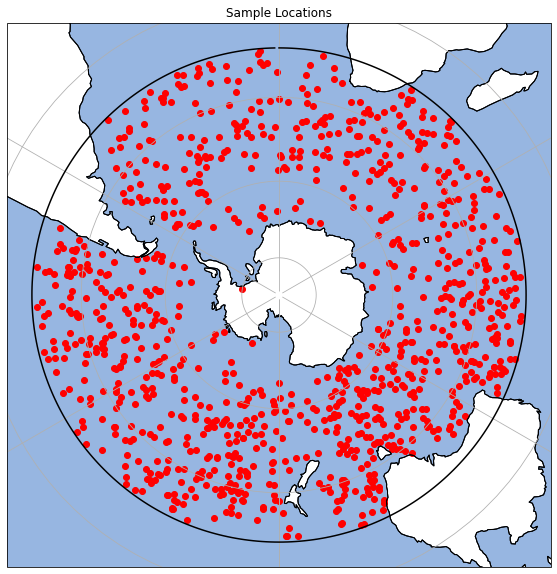

In [11]:
sampleFloatLocations = pickRand(dfFloatLoc, 1000)
locationPlot(sampleFloatLocations, (10,10), 1)

<br>
<b>Latitude and Longitude distribution of large sample</b>

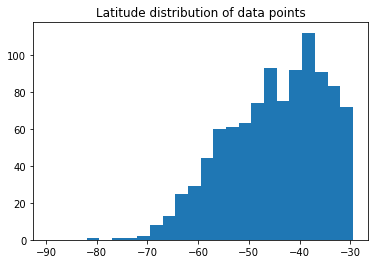

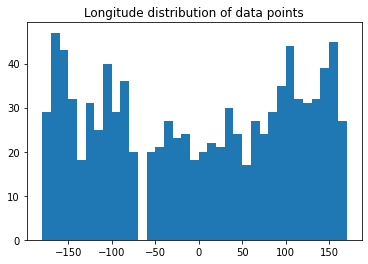

In [12]:
latDistribution(sampleFloatLocations, 1)
lonDistribution(sampleFloatLocations, 2)

<br>
<b>Latitude and Longitude distribution of large sample, compared to distributions of original data set</b>

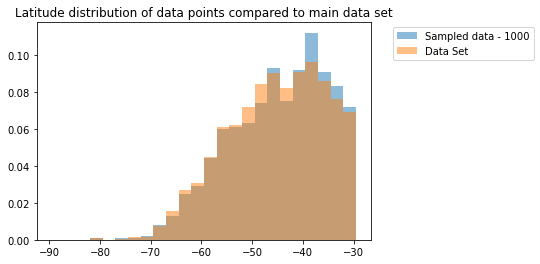

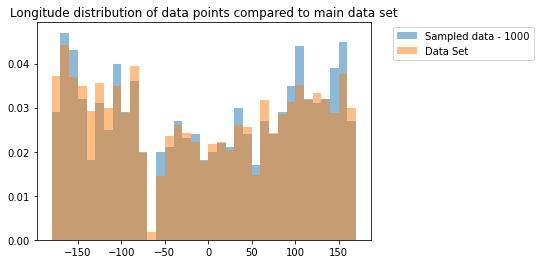

In [13]:
latDistributionCompare(sampleFloatLocations, dfFloatLoc, 1)
lonDistributionCompare(sampleFloatLocations, dfFloatLoc, 2)